In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import gaussian_kde
import os.path
import sys
import geopandas
from geopy.geocoders import Nominatim
import pycountry_convert

#Using Gregors code

In [2]:
# haversine formula to compute distance on a sphere, using mean Earth radius
def haversine(lat0,lon0,lat1,lon1):
    radius = 6371.0088 # mean Earth radius in km

    d_lat = np.radians(lat1-lat0)
    d_lon = np.radians(lon1-lon0)
    sin2 = (np.sin(d_lat/2.)**2 +
           np.cos(np.radians(lat0))*np.cos(np.radians(lat1))*np.sin(d_lon/2.)**2)
    unit_dist = 2.*np.arctan2(np.sqrt(sin2),np.sqrt(1.-sin2))
    
    return radius*unit_dist

# given a list of city names in <cities>, use geopy.geocoders Nominatim API to
#   request coordinates and 'best match' full location strings online
# returns three lists of: latitude, longitude, location-string
#   if a city was not found, return coordinates are set to NaN, and
#   and return strings to 'NA (original_name)'
def get_coordinates(cities):
    cities = np.array(cities,dtype=object)
    
    i_sort = np.argsort(cities)
    
    cities_sorted = cities[i_sort]
    
    # always include index 0, and include indices i where cities_sorted[i]!=cities_sorted[i-1]
    # to avoid requesting data for a city more than once
    i_check = np.concatenate(([0],np.where(cities_sorted[1:]!=cities_sorted[:-1])[0]+1),axis=None)
        
    lat_sorted=np.ndarray(cities_sorted.shape)
    lon_sorted=np.ndarray(cities_sorted.shape)
    name_sorted=np.ndarray(cities_sorted.shape,dtype=object)

    # assign coordinates and names found through geopy at indices <i_check>, to
    # only include unique city names once:
    k = 0
    for i in i_check:
        location_code = geo_app.geocode(cities_sorted[i])
        if location_code is None:
            lat_sorted[i] = float('NaN')
            lon_sorted[i] = float('NaN')
            name_sorted[i] = 'NA ('+cities_sorted[i]+')'
            continue
        # if the place was found, get location raw data:
        location = location_code.raw
        lat_sorted[i] = location['lat']
        lon_sorted[i] = location['lon']
        name_sorted[i] = location['display_name']
        k += 1
        if k%10 == 0:
            print(f"{i}/{len(cities_sorted)} cities processed")

    # assign coordinates and names to duplicate cities:
    for i in range(1,cities_sorted.shape[0]):
        if name_sorted[i] is not None: continue
        lat_sorted[i] = lat_sorted[i-1]
        lon_sorted[i] = lon_sorted[i-1]
        name_sorted[i] = name_sorted[i-1]
        
    lat=np.ndarray(cities_sorted.shape)
    lon=np.ndarray(cities_sorted.shape)
    name=np.ndarray(cities_sorted.shape,dtype=object)

    # reverse sorting:
    lat[i_sort] = lat_sorted
    lon[i_sort] = lon_sorted
    name[i_sort] = name_sorted
    
    return lat,lon,name

# plot global map with travel destinations and monthly CO2eq emissions in a specific monthly interval
class canimatedmap:
    def __init__(self,lat,lon,times,durations,distances,co2eq,show_densities=False,fadeout_time=0.0):
        # some configuration variables
        # note: should be added as function arguments once stable
        # change color depending on density
        self.show_densities = show_densities
        # each point is visible for an additional fadeout_time months after return with decreasing opacity
        self.fadeout_time = float(fadeout_time)
        # increase point size by CO2eq
        self.vary_size_by_co2 = True
        # show straight arrows to destination (great circles would be cooler but I did not get to it)
        self.show_arrows = False
        
        self.x = lon
        self.y = lat
        self.t = times
        self.dt = durations
        self.d = distances
        self.eq = co2eq
        self.prepare_data()
        
    def set_fadeout_time(self,fadeout_time):
        self.fadeout_time=float(fadeout_time)
        
    def set_show_densities(self,show_densities):
        self.show_densities=show_densities
        
    def prepare_data(self):
        # (1) exclude NaN coordinates for plotting and
        # (2) remove place of origin from destinations by excluding zero distances
        cut = np.logical_or(np.logical_not(np.isnan(self.x)),self.d>0)
        self.x = self.x[cut]
        self.y = self.y[cut]
        self.t = self.t[cut]
        self.dt = self.dt[cut]
        self.d = self.d[cut]
        self.eq = self.eq[cut]

        # convert dt to months
        days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31],dtype=float)
        for i in range(12):
            cut = np.mod(self.t,12)==i
            self.dt[cut] = self.dt[cut]/days_in_month[i]

        # sort by return time for vanishing destinations (plot later over earlier points)
        idx = (self.t+self.dt).argsort()
        self.x = self.x[idx]
        self.y = self.y[idx]
        self.t = self.t[idx]
        self.dt = self.dt[idx]
        self.d = self.d[idx]
        self.eq = self.eq[idx]
        
        self.n_months = self.t.max()+1 # number of months in the sequence

        # create monthly co2eq list:
        list_co2 = []
        for i in range(self.n_months):
            list_co2.append(self.eq[np.logical_and(self.t>=i,self.t<i+1)].sum())
        self.co2=np.array(list_co2)
            
        # set up x-ticks position  
        self.xtick_x = np.arange(self.n_months)

        # set up x-ticks label   
        xtick_label = xtick_label1 = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        xtick_label[0] = str(year0)
        
        for i in range(self.n_months//12):
            xtick_label = xtick_label + xtick_label1
            xtick_label[12*(i+1)] = str(year0+i+1)
        
        self.xtick_label = np.array(xtick_label,dtype=object)
        self.xtick_label = xtick_label[:self.n_months]

        # set up world data for plotting
        self.world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
        
    def get_months(self):
        return self.n_months
    
    def plot_scatter(self,ax,x1,y1,d1,eq1,alpha=1.0):
        if x1.size==0:
            return
        
        if self.show_densities:
            # get local density
            xy = np.vstack([x1,y1])
            if x1.shape[0]>1:
                try:
                    z1 = gaussian_kde(xy,bw_method=0.05)(xy)
                except np.linalg.linalg.LinAlgError:
                    z1 = np.zeros(x1.shape)
            else:
                z1 = np.zeros(x1.shape)
            # sort by density, and plot densest points last
            idx = z1.argsort()
            x1,y1,z1 = x1[idx],y1[idx],z1[idx]
            d1,eq1 = d1[idx],eq1[idx]
            c=z1
            # scale c from 0 to 1 (or set to 0 in case it is uniform)
            if(c.min()<c.max()):
                c=(c-c.min())/(c.max()-c.min())
            else:
                c=np.zeros(c.shape)
            # apply a colormap
            cmap = plt.cm.Reds
            c=cmap(1.0-0.5*c)
        else:
            c='#c00000'
            
        if self.vary_size_by_co2:
            s=48.0*eq1**0.5
        else:
            s=32.0

        ax.scatter(x1,y1,c=c,s=s,edgecolors='none',alpha=alpha)
        

    # stepsize is the stepsize in months used with fadeout_time to plot difference opacities over time
    def plot(self,month_0,month_1=-1.0,filename=None,stepsize=0.1,show_plot=True):
        if month_0 >= self.n_months+1.0:
            return False
        
        if month_1 < month_0:
            month_1 = month_0+1.0
                    
        fig = plt.figure(figsize=(12,8)) # "fig = " omitted
        gs = gridspec.GridSpec(2,1,height_ratios=[10,2])
        ax0 = plt.subplot(gs[0])
        # plot destination density
        self.world.plot(ax=ax0,color='#c6c6c6',edgecolor=None)
            
        # optionally display arrows in the map
        if self.show_arrows:
            x0 = lon0*np.ones(x1.shape)
            y0 = lat0*np.ones(y1.shape)
            for i in range(x1.shape[0]):
                ax0.arrow(x0[i],y0[i],x1[i]-x0[i],y1[i]-y0[i],head_width=1,head_length=1,fc='k',ec='k')
                
        # overlay scatter plot
        # set alpha to 1.0 if there is overlap of [t,t+dt] with [month_0,month_1[:
        cut = np.logical_and(self.t+self.dt>=month_0,self.t<month_1)
        self.plot_scatter(ax0,self.x[cut],self.y[cut],self.d[cut],self.eq[cut])
        # months up to the current month can be visible depending on the fadeout_time after return
        if self.fadeout_time>0:
            for m in np.arange(month_0-stepsize*np.ceil(self.fadeout_time/stepsize),month_0,stepsize):
                # m corresponds to the return time
                cut = np.logical_and(self.t+self.dt>=m,self.t+self.dt<m+stepsize)
                alpha = max( 0.0 , 0.4 * ( 1.0 - (month_0-m)/self.fadeout_time ) )
                self.plot_scatter(ax0,self.x[cut],self.y[cut],self.d[cut],self.eq[cut],alpha)
            
        ax0.axis(False)
        
        # plot CO2eq for each month up to month_1
        ax1 = plt.subplot(gs[1])
        ax1.set_ylim([0,self.co2.max()])
        ax1.set_xlim([-0.5,self.n_months-0.5])
        ax1.bar(self.xtick_x,np.select([self.xtick_x<int(np.ceil(month_1)),self.xtick_x>=int(np.ceil(month_1))],
                                       [self.co2,np.zeros(self.n_months)]),width=0.8,align='center')
        if month_0>0.0 or month_1<self.n_months:
            if month_1-month_0>0.8:
                width=month_1-month_0-0.2
            else:
                width=month_1-month_0
            ax1.bar(month_0-0.4,self.co2.max(),width=width,align='edge',color='#000000',alpha=0.2)
        ax1.set_xticks(self.xtick_x)
        ax1.set_xticklabels(self.xtick_label,rotation=45)
        ax1.set_ylabel('co2eq [t]')
        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename)
        if show_plot:
            plt.show()
        plt.close(fig)

In [3]:
x = np.genfromtxt('../data/travel_list_reduced.csv', delimiter=",", names = True, dtype = None, encoding = 'utf-8')
print(len(x),x.dtype)
x = x.view(np.recarray)

7 [('Reisedauer', '<i8'), ('Zielort_der_Reise', '<U12'), ('Reiselandländergr', '<U2'), ('Reislaenge', '<U8'), ('Reisezweck', '<U13'), ('month', '<i8'), ('year', '<i8')]


In [4]:
# instantiate a new Nominatim client to request location data online
geo_app = Nominatim(user_agent="co2parsing")

load_files = True

year0 = x.year.min()

list_cities = []
list_times = []
list_durations = []
for i in range(len(x)):
    dest = ""
    dest += x.Zielort_der_Reise[i]
    dest += ", "
    dest += x.Reiselandländergr[i]
    list_cities.append(dest)
    list_times.append(12*(x.year[i]-year0)+x.month[i]-1) # month since Jan in the first year (0-indexed)
    list_durations.append(x.Reisedauer[i])               # duration in days
cities = np.array(list_cities,dtype=object)
times = np.array(list_times,dtype=int)
durations = np.array(list_durations,dtype=float)
print(cities)

lat0,lon0,name0 = get_coordinates(['Heidelberg'])
print(get_coordinates(['Heidelberg']))

['Los Angeles, US' 'Perth, AU' 'Peking, CN' 'Madrid, ES' 'Göteburg, SE'
 'Noordwyjk, NL' 'Wernigerrode, DE']
(array([49.4093582]), array([8.694724]), array(['Heidelberg, Baden-Württemberg, Deutschland'], dtype=object))


In [5]:
# Cleaning of cities after inspection of results check weired distances/destinations and nan values below
# city name replacements:

# Simple replacement

input_list = ['Wernigerrode, DE','Noordwyjk, NL', 'Göteburg, SE']
replacement_list = ['Wernigerode, DE','Noordwijk, NL', 'Göteborg, SE']
for inp,rep in zip(input_list,replacement_list):
    print(inp," --> ",rep)
    cities[np.where(cities == inp)] = rep

Wernigerrode, DE  -->  Wernigerode, DE
Noordwyjk, NL  -->  Noordwijk, NL
Göteburg, SE  -->  Göteborg, SE


In [6]:
#Pulling the replacements back into the original array

country_code = []
for i,item in enumerate(cities):
    if item.split()[-1] != x.Reiselandländergr[i]:
        #print(item.split()[-1],x.Reiselandländergr[i])
        x.Reiselandländergr[i] = item.split()[-1]
        #print(item.split()[-1],x.Reiselandländergr[i])
        #print(item,x.Zielort_der_Reise[i])
        x.Zielort_der_Reise[i] = item.split()[0]
        print(x.Zielort_der_Reise[i], x.Reiselandländergr[i])
        #print('######################')

In [7]:
if load_files:
    if not os.path.isfile('../data/parse_data.npz'):
        print("data file does not exist: requesting data online")
        load_files=False
        
if load_files: # load data from previous run:
    try:
        data = np.load('../data/parse_data.npz',allow_pickle=True)
        cities_file = data['cities']
        if cities_file.shape==cities.shape and np.all(cities_file==cities):
            print("data loaded from file")
            lat  = data['lat']
            lon  = data['lon']
            name = data['name']
        else:
            print("existing file contains data for different cities: requesting data online")
            load_files = False
    except IOError:
        print(IOError)
        print("loading arrays from file failed: requesting data online")
        load_files = False

if not load_files:
    # get coordinates and location strings online:
    lat,lon,name = get_coordinates(cities)
    
    # store data for later use:
    np.savez('../data/parse_data.npz',lat=lat,lon=lon,name=name,cities=cities)

data loaded from file


In [8]:
dist = haversine(lat0,lon0,lat,lon)# check list
for i in range(len(cities)):
    print(i, cities[i], "-->", name[i], lat[i], lon[i])
    print("###################################")

0 Los Angeles, US --> Los Angeles, Los Angeles County, California, United States 34.0536909 -118.242766
###################################
1 Perth, AU --> Perth, City of Perth, Western Australia, 6000, Australia -31.9527121 115.8604796
###################################
2 Peking, CN --> 北京市, 100051, 中国 39.906217 116.3912757
###################################
3 Madrid, ES --> Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España 40.4167047 -3.7035825
###################################
4 Göteborg, SE --> Göteborg, Göteborgs Stad, Västra Götalands län, 41106, Sverige 57.7072326 11.9670171
###################################
5 Noordwijk, NL --> Noordwijk, Zuid-Holland, Nederland 52.2698936 4.452685652490141
###################################
6 Wernigerode, DE --> Wernigerode, Landkreis Harz, Sachsen-Anhalt, Deutschland 51.8344172 10.7862526
###################################


In [9]:
# check NANs
cut = np.isnan(lon)
cities[cut]

array([], dtype=object)

In [10]:
dist = haversine(lat0,lon0,lat,lon)
print("total distance traveled 1 way in km: ",sum(dist))

total distance traveled 1 way in km:  34105.27128088894


In [11]:
# assuming 350g per traveled km:
# We can improve upon that by interpolating table data from Didier Barret (I have requested the data)
# or we could use other data
kgco2perkm = 0.25 
increased_distance = 0.2
return_flight = 2
co2emitted = sum(dist) * kgco2perkm * (1 + increased_distance) * return_flight
print("CO2 in tons: ",co2emitted/1000 )

CO2 in tons:  20.463162768533362


In [12]:
# This is now an alternative way to calulate the CO2equivalent emission

def km2co2eq(dist,km_below_no_flying = 500, km_above_which_all_flying = 2000, km2co2_train = 0.1):
    """
    function to calculate CO2 equivalent per km
    INPUT
       dist = distance in km as an array or single value in a list, e.g. [1000]
       km_below_no_flying = below which distance we dont fly (in km)
       km2co2_for_below = conversion factor for non flights
    OUTPUT
       CO2 consumption for the input distances (as an array)
    """
    #making compatible for single scalars
    dist = np.hstack(dist)       
    # Loading data from Didier Barret
    x = np.genfromtxt("../data/Didier_Barret_km_to_co2.csv", delimiter= ",", names = True, dtype = None,
                 skip_header=1)
    x = x.view(np.recarray)
    x = np.sort(x,order = "distance_km")
    # Replacing the inf value for zero
    x.emission_factors_CO2eq_kg_per_km[0] = x.emission_factors_CO2eq_kg_per_km[1]
    # Replacing low distances by train
    x.emission_factors_CO2eq_kg_per_km[x.distance_km<km_below_no_flying] = km2co2_train
    # Taking a linear interpolation inbetween
    cut = (x.distance_km>km_below_no_flying) & (x.distance_km<km_above_which_all_flying)
    x.emission_factors_CO2eq_kg_per_km[cut] = np.interp(x.distance_km[cut],
                                                        [km_below_no_flying,km_above_which_all_flying],
                                                       [km2co2_train,x.emission_factors_CO2eq_kg_per_km[x.distance_km>km_above_which_all_flying][0]])
    assert(np.all(dist >= 0))
    # linear interpolation for all distances
    co2eqperkm = np.interp(dist,x.distance_km,x.emission_factors_CO2eq_kg_per_km)
    #co2eqperkm[dist<km_below_no_flying] = km2co2_train
    result = dist * co2eqperkm
    return(result)

Text(0.5, 0, 'km')

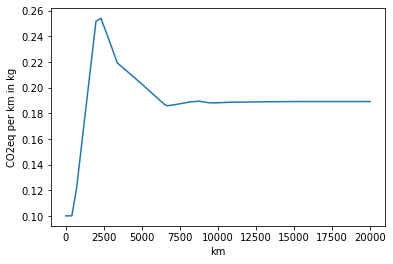

In [13]:
# example km2co2eq conversion
xax = np.arange(1,20000)
yax = km2co2eq(xax)
yax /= xax
plt.plot(xax,yax)
plt.ylabel("CO2eq per km in kg")
plt.xlabel("km")

In [14]:
# increasing the distance because straight line is not always possible
dist *= 1.2
one_way = km2co2eq(dist)
# Adding the return way
two_ways = 2*one_way
# conversion to tons
two_ways *= 0.001
print(sum(two_ways))
np.savetxt('../data/two_ways.txt', two_ways)

15.350094884661454


In [15]:
#Problems with the distance classifier, replace far away destinations:
for i in range(len(x)):
    if x.Reislaenge[i] in ['Europe','Germany','Local', '']:
        if two_ways[i] > 2:
            print(x[i], two_ways[i])
            x.Reislaenge[i] = 'Overseas'
    if x.Reislaenge[i] =='':
        if two_ways[i] < 2:
            print(x[i], two_ways[i])
            x.Reislaenge[i] = 'Europe'

In [16]:
#co2emittedtons = (dist * kgco2perkm * (1 + increased_distance) * return_flight) * 0.001
dist_sort = np.argsort(dist)
print("ascending distance, distance in km, destination, co2equivalent emission in tons")
for i in range(len(dist)):
    print(i,"%.1f" %dist[dist_sort][i], cities[dist_sort[i]],'%.3f' %(two_ways[dist_sort[i]]))

ascending distance, distance in km, destination, co2equivalent emission in tons
0 368.8 Wernigerode, DE 0.074
1 522.8 Noordwijk, NL 0.113
2 1136.8 Göteborg, SE 0.376
3 1672.9 Madrid, ES 0.737
4 9393.8 Peking, CN 3.535
5 11233.5 Los Angeles, US 4.238
6 16597.8 Perth, AU 6.277


In [17]:
# For comparison.
# Sydney 7.5t, atmosfair: 13t, co2.myclimate.org: 5.8t
# Santiago de Chile 5.5t, atmosfair: 8.7t,
# Tuscon 4.1t, atmosfair 5.9t
# Beijing 3.5t, atmosfair 4.9t
# New York 2.8t, atmosfair: 3.7t

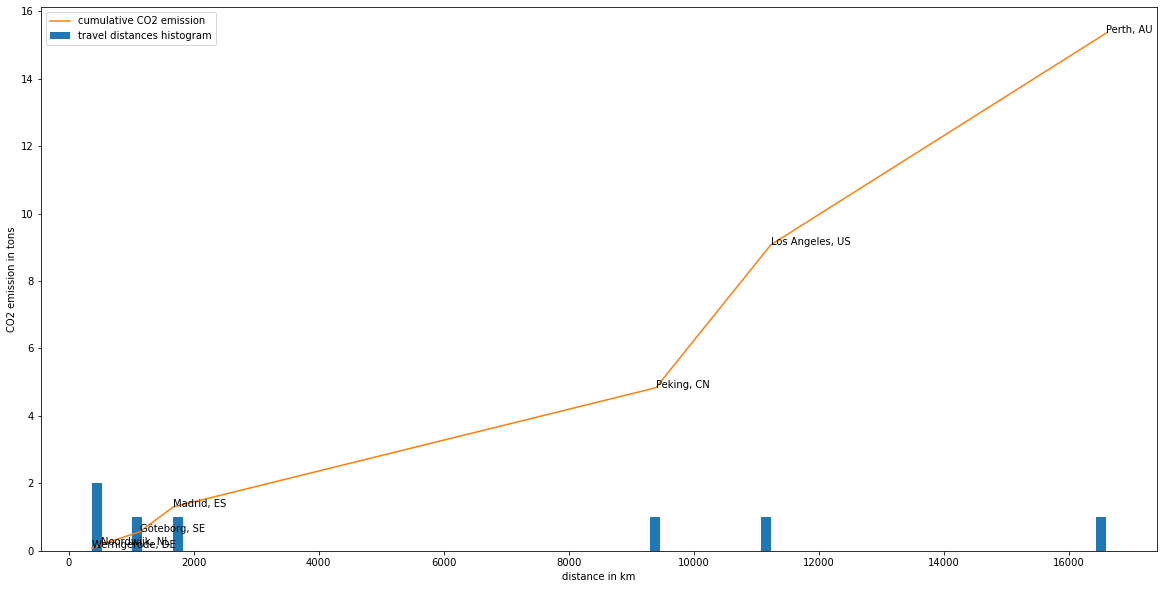

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(20,10))
_ = plt.hist(dist, bins = 100, label = "travel distances histogram")
plt.plot(dist[dist_sort],np.cumsum(two_ways[dist_sort]), label = "cumulative CO2 emission")
for i in range(len(dist)):
    plt.text(dist[dist_sort][i],np.cumsum(two_ways[dist_sort])[i],cities[dist_sort].astype(str)[i])
plt.xlabel("distance in km")
plt.ylabel("CO2 emission in tons")
plt.legend(loc = "best")
plt.show()
plt.clf()

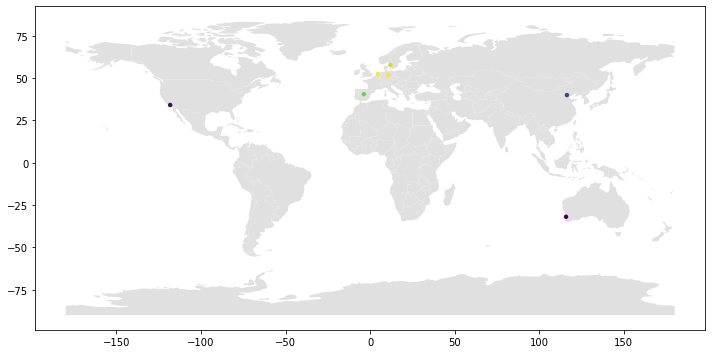

In [19]:
# exclude NaN coordinates for plotting
xax = lon[np.logical_not(np.isnan(lon))]
yax = lat[np.logical_not(np.isnan(lon))]

# remove place of origin from destinations by excluding zero distances
d = dist[np.logical_not(np.isnan(lon))]
xax = xax[d>0]
yax = yax[d>0]

# get local density
xy = np.vstack([xax,yax])
zax = gaussian_kde(xy)(xy)

# sort by density, and plot densest points last
idx = zax.argsort()
xax,yax,zax = xax[idx],yax[idx],zax[idx]

# set up world data for plotting
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# plot destination density
world.plot(figsize=(12,10),color='#e0e0e0')
plt.scatter(xax,yax,c=zax,s=20,edgecolors='none')
plt.show()

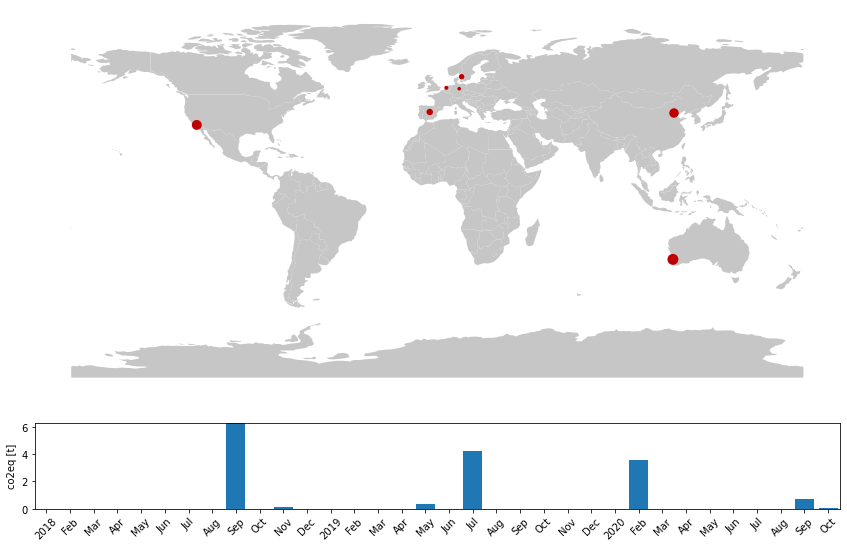

In [20]:
# instantiate class to draw a word map with travel locations overlayed:
animatemap = canimatedmap(lat,lon,times,durations,dist,two_ways,fadeout_time=3.0)
if False:
    stepsize=1.0 # set to 1.0 for a GIF
    i=0
    for m in np.arange(0.0,animatemap.get_months(),stepsize):
        print(f"{i}/{animatemap.get_months()/stepsize-1}")
        # to write to a file only set show_plot to False:
        animatemap.plot(m,m+stepsize,'map_animated_{:04}.png'.format(i),stepsize=stepsize,show_plot=False)
        i=i+1
    
# plot map for all months:
animatemap.plot(0,animatemap.get_months())

In [21]:
count, invidx, ct = np.unique(x.Reiselandländergr,return_inverse=True, return_counts=True)
print('destination country, co2 in tons, number of travels, average co2/travel' )
for i,item in enumerate(count):
    print(item,"%6.2f,   %4d,    %.1f" %(sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

destination country, co2 in tons, number of travels, average co2/travel
AU   6.28,      1,    6.3
CN   3.53,      1,    3.5
DE   0.07,      1,    0.1
ES   0.74,      1,    0.7
NL   0.11,      1,    0.1
SE   0.38,      1,    0.4
US   4.24,      1,    4.2


In [22]:
count, invidx, ct = np.unique(x.year,return_inverse=True, return_counts=True)
print('year, co2 in tons, number of travels, average co2/travel' )
for i,item in enumerate(count):
    print(item,"%6.2f,   %4d,    %.1f" %(sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

year, co2 in tons, number of travels, average co2/travel
2018   6.39,      2,    3.2
2019   4.61,      2,    2.3
2020   4.35,      3,    1.4


In [23]:
count, invidx, ct = np.unique(x.month,return_inverse=True, return_counts=True)
print('month','co2 in tons', 'number of travels', 'average co2/travel' )
for i,item in enumerate(count):
    print("%4d,  %7.2f,   %4d,    %.1f" %(item,sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

month co2 in tons number of travels average co2/travel
   2,     3.53,      1,    3.5
   5,     0.38,      1,    0.4
   7,     4.24,      1,    4.2
   9,     7.01,      2,    3.5
  10,     0.07,      1,    0.1
  11,     0.11,      1,    0.1


In [24]:
count, invidx, ct = np.unique(x.Reisedauer,return_inverse=True, return_counts=True)
print('travel length in days','co2 in tons', 'number of travels', 'average co2/travel' )
for i,item in enumerate(count):
    print("%4d,  %7.2f,   %4d,    %.1f" %(item,sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

travel length in days co2 in tons number of travels average co2/travel
   1,     0.07,      1,    0.1
   2,     0.11,      1,    0.1
   3,     0.74,      1,    0.7
   7,     3.91,      2,    2.0
  10,     4.24,      1,    4.2
  15,     6.28,      1,    6.3


In [25]:
count, invidx, ct = np.unique(x.Reislaenge,return_inverse=True, return_counts=True)
print('destination','co2 in tons', 'number of travels', 'average co2/travel' )
for i,item in enumerate(count):
    print("%000s,  %7.2f,   %4d,    %.1f" %(item,sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

print('\n     destination, percent CO2eq, percent of travels' )
for i,item in enumerate(count):
    print("%016s,       %7.3f,          %7.3f"%(item,
                                                 100.0*sum(two_ways[invidx==i])/sum(two_ways),
                                                 100.0*ct[i]/sum(ct)))    

destination co2 in tons number of travels average co2/travel
Europe,     0.85,      2,    0.4
Germany,     0.07,      1,    0.1
Overseas,    14.43,      4,    3.6

     destination, percent CO2eq, percent of travels
          Europe,         5.543,           28.571
         Germany,         0.481,           14.286
        Overseas,        93.976,           57.143


In [26]:
continents = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'OC': 'Australia',
    'SA': 'South America', 
}

# unique country codes, e.g. 'DE'
countrycode_unique = np.unique(x.Reiselandländergr)

# convert country code to continent code, e.g. 'DE' to 'EU'
list_continent_alpha2 = []
for a2 in countrycode_unique:
    list_continent_alpha2.append(pycountry_convert.country_alpha2_to_continent_code(a2))

# set up country code to continent dict
countrycode_continent = { x:continents[y] for (x,y) in zip(countrycode_unique,list_continent_alpha2)}

# convert destination country codes to continent and 'Germany'
destination = np.array(x.Reiselandländergr,dtype=object)
for alpha2 in countrycode_unique:
    destination[destination==alpha2] = countrycode_continent[alpha2]
destination[x.Reiselandländergr=='DE'] = 'Germany'

count, invidx, ct = np.unique(destination, return_inverse=True, return_counts=True)
print('     destination, CO2eq in tons, number of travels, average co2/travel' )
for i,item in enumerate(count):
    print("%016s,       %7.2f,              %4d, %.1f"%(item,
                                                      sum(two_ways[invidx==i]),
                                                      ct[i],
                                                      sum(two_ways[invidx==i])/ct[i]))
    
print('\n     destination, percent CO2eq, percent of travels' )
for i,item in enumerate(count):
    print("%016s,       %7.3f,          %7.3f"%(item,
                                                 100.0*sum(two_ways[invidx==i])/sum(two_ways),
                                                 100.0*ct[i]/sum(ct)))
print('\nexcluding Africa:')
idx = np.where(destination!='Africa')
count, invidx, ct = np.unique(destination[idx], return_inverse=True, return_counts=True)

print('\n     destination, percent CO2eq, percent of travels' )
for i,item in enumerate(count):
    print("%016s,       %7.3f,          %7.3f"%(item,
                                                 100.0*sum(two_ways[idx][invidx==i])/sum(two_ways[idx]),
                                                 100.0*ct[i]/sum(ct)))

     destination, CO2eq in tons, number of travels, average co2/travel
            Asia,          3.53,                 1, 3.5
       Australia,          6.28,                 1, 6.3
          Europe,          1.23,                 3, 0.4
         Germany,          0.07,                 1, 0.1
   North America,          4.24,                 1, 4.2

     destination, percent CO2eq, percent of travels
            Asia,        23.027,           14.286
       Australia,        40.893,           14.286
          Europe,         7.993,           42.857
         Germany,         0.481,           14.286
   North America,        27.606,           14.286

excluding Africa:

     destination, percent CO2eq, percent of travels
            Asia,        23.027,           14.286
       Australia,        40.893,           14.286
          Europe,         7.993,           42.857
         Germany,         0.481,           14.286
   North America,        27.606,           14.286


In [27]:
count, invidx, ct = np.unique(x.Reisezweck,return_inverse=True, return_counts=True)
print('category','co2 in tons', 'number of travels', 'average co2/travel' )
for i,item in enumerate(count):
    print("%000s,  %7.2f,   %4d,    %.1f" %(item,sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

category co2 in tons number of travels average co2/travel
Collaboration,     6.39,      2,    3.2
Comissioning,     3.53,      1,    3.5
Conference,     4.24,      1,    4.2
Observation,     0.45,      2,    0.2
Other,     0.74,      1,    0.7


In [28]:
count, invidx, ct = np.unique(x.Zielort_der_Reise,return_inverse=True, return_counts=True)
print('city','co2 in tons', 'number of travels', 'average co2/travel' )
for i,item in enumerate(count):
    print("%000s,  %7.2f,   %4d,    %.1f" %(item,sum(two_ways[invidx==i]),ct[i],sum(two_ways[invidx==i])/ct[i]))

city co2 in tons number of travels average co2/travel
Göteburg,     0.38,      1,    0.4
Los Angeles,     4.24,      1,    4.2
Madrid,     0.74,      1,    0.7
Noordwyjk,     0.11,      1,    0.1
Peking,     3.53,      1,    3.5
Perth,     6.28,      1,    6.3
Wernigerrode,     0.07,      1,    0.1


In [29]:
cutpre = (x.year == 2018) | (x.year == 2019) | (x.year == 2020) & (x.month < 3)
duration_pre = 26 #month
cutpost = (x.year == 2020) & (x.month > 3)
duration_post = 8 # month
cut = (x.year == 2020) & (x.month == 3)
duration = 1 # month
nAstronomers = 150

In [30]:
print('pre-covid, post-covid, march 2020, German pledge')
pre = 12*sum(two_ways[cutpre])/(duration_pre*nAstronomers)
post = 12*sum(two_ways[cutpost])/(duration_post*nAstronomers)
print(12*sum(two_ways[cutpre])/(duration_pre*nAstronomers),
      12*sum(two_ways[cutpost])/(duration_post*nAstronomers),
      12*sum(two_ways[cut])/(duration*nAstronomers),
     6.8)

pre-covid, post-covid, march 2020, German pledge
0.044735135991911264 0.008111756872902953 0.0 6.8


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


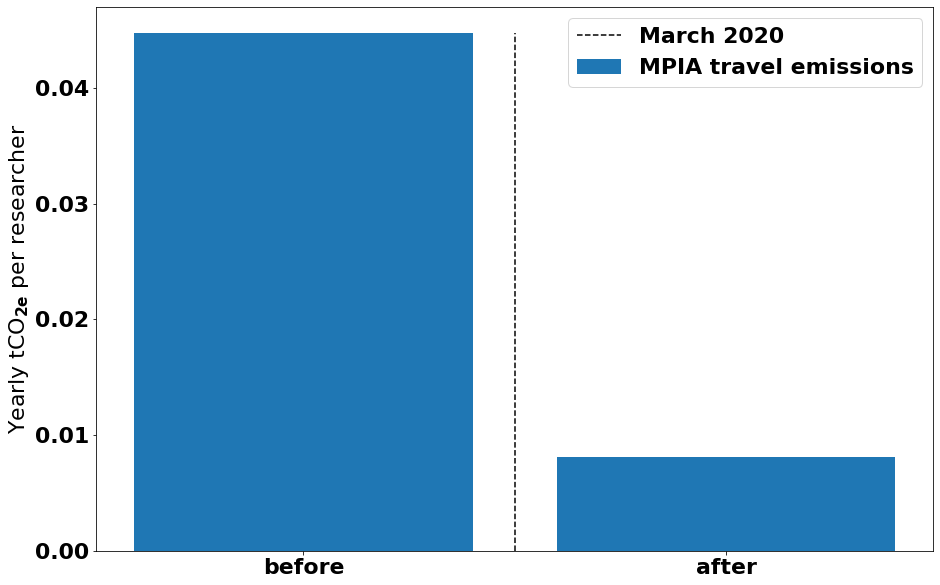

In [31]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
#, 'German pledge 2030'
labels = ['before', 'after']
plt.figure(figsize=(15,10))
plt.bar([0.,1.],[pre,post], label = 'MPIA travel emissions')
plt.vlines(0.5,0.,pre, ls = '--',label = 'March 2020')

#plt.hlines(2,-0.5,1.5, label = 'sustainable per Person')
plt.ylabel(r'Yearly tCO$_\mathrm{2e}$ per researcher')
plt.gca().set_xticks([0,1])
plt.gca().set_xticklabels(labels)
#plt.ylim((0,4))
plt.yscale('linear')
plt.legend(loc = 'best')

In [32]:
# Make a file that can be read in by Didiers Tool:
#print(len(cities))
#cities = cities[cities != 'Heidelberg, DE']
##print(len(cities))
#cities = cities[cities != 'heidelberg, DE']
#print(len(cities))

In [33]:
# For all cities Didier Barrets tool gave: https://travel-footprint-calculator.irap.omp.eu/estimation/2021-03-26_13:48:14_37e2.html
# a few minor problems with city finding, but overall quite good
# Overseas results where listed here: https://travel-footprint-calculator.irap.omp.eu/estimation/2021-03-26_14:10:55_cff4.html
# Also a few things that are off.
# This was the result for the alternative output: https://travel-footprint-calculator.irap.omp.eu/estimation/2021-03-26_14:29:02_49bd.html

In [34]:
cut = (x.Reislaenge == "Overseas")
print(cities[cut])

['Los Angeles, US' 'Perth, AU' 'Peking, CN' 'Göteborg, SE']


In [35]:
# The resulting file can be used as input in the CO2 calculator by Didier Barret: \
# https://travel-footprint-calculator.irap.omp.eu/
with open('../data/barret_tool_input.csv', 'w') as the_file:
    the_file.write('City, Country\n')
    for i in range(len(cities[cut])):
        the_file.write('%s\n' %(cities[cut][i]))


In [36]:
print(cities[cut])

['Los Angeles, US' 'Perth, AU' 'Peking, CN' 'Göteborg, SE']


In [37]:
#with open('barret_tool_alt.csv', 'w') as the_file:
#    the_file.write('City, Country\n')
#    for i in range(len(name)):
#        the_file.write('%s, %s\n' %(name[i].split(',')[0].strip(),name[i].split(',')[-1].strip()))
#
#for i in range(len(name)):
#    print(name[i].split(',')[0].strip(),',',name[i].split(',')[-1].strip())

In [38]:
#with open('barret_tool_overseas_alt.csv', 'w') as the_file:
#    the_file.write('City, Country\n')
#    for i in range(len(name[cut])):
#        the_file.write('%s, %s\n' %(name[cut][i].split(',')[0].strip(),name[cut][i].split(',')[-1].strip()))
#
#for i in range(len(name[cut])):
#    print(name[cut][i].split(',')[0].strip(),',',name[cut][i].split(',')[-1].strip())